In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from tqdm import tqdm
from scipy import stats
import seaborn
import matplotlib.pyplot as plt
from graspy.simulations import er_np
from graspy.embed import AdjacencySpectralEmbed
from graspy.inference import LatentDistributionTest

In [2]:
p = 0.8
n = 500
m = 50

np.random.seed(314)

A = er_np(n, p**2)
B = er_np(m, p**2)

ase_X = AdjacencySpectralEmbed(n_components=1)
X_hat = ase_X.fit_transform(A)

ase_Y = AdjacencySpectralEmbed(n_components=1)
Y_hat = ase_Y.fit_transform(B)

all_ases = np.concatenate([X_hat, Y_hat])
permuted_ases = np.random.permutation(all_ases)
X_hat_permuted = permuted_ases[:n]
Y_hat_permuted = permuted_ases[n:]

In [3]:
granular = 10000
bot = 0.4
top = 1.2
nbins = 25

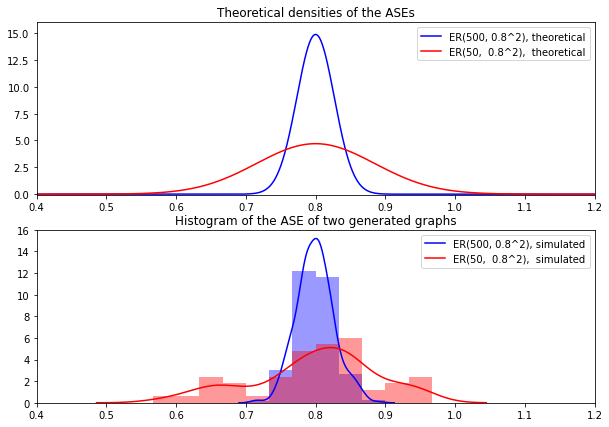

In [4]:
# fig01, (ax01, ax02, ax03) = plt.subplots(3, 1, figsize=(10, 10))#, sharex=True)
fig01, (ax01, ax02) = plt.subplots(2, 1, figsize=(10, 7))#, sharex=True)

# Theoretical distribution of the 
ax01.plot(np.linspace(bot, top, granular), 
          stats.norm.pdf(np.linspace(bot, top, granular), p, np.sqrt((1-p**2)/n)),
         color="b", label="ER({}, {}^2), theoretical".format(n,p))
ax01.plot(np.linspace(bot, top, granular), 
          stats.norm.pdf(np.linspace(bot, top, granular), p, np.sqrt((1-p**2)/m)),
         color="red", label="ER({},  {}^2),  theoretical".format(m,p))
ax01.set_title("Theoretical densities of the ASEs")
ax01.set_xlim([bot, top])
ax01.set_ylim(-0.1, 16)
ax01.legend()
# Histogram/KDE generated from a graph
seaborn.distplot(X_hat, bins=np.linspace(bot, top, nbins), ax=ax02,
                 hist_kws={"alpha": 0.4, "color": "b"},
                 kde_kws={"alpha": 1, "color":"b",
                          "label":"ER({}, {}^2), simulated".format(n,p)})
seaborn.distplot(Y_hat, bins=np.linspace(bot, top, nbins), ax=ax02,
                 hist_kws={"alpha": 0.4, "color": "red"},
                kde_kws={"alpha": 1, "color":"red",
                         "label":"ER({},  {}^2),  simulated".format(m,p)})
ax02.set_title("Histogram of the ASE of two generated graphs")
ax02.set_xlim([bot, top])
ax02.set_ylim(0, 16);


In [5]:
fig01.savefig("../figures/visualization_nonvalidity.png", bbox_inches='tight')

In [6]:
# make the same figure for the modified ASS

In [7]:
def fit_plug_in_variance_estimator(X):
    '''
    Takes in ASE of a graph and returns a function that estimates
    the variance-covariance matrix at a given point using the
    plug-in estimator from the RDPG Central Limit Theorem.
    (Athreya et al., RDPG survey, Equation 10)
    
    X : adjacency spectral embedding of a graph
        numpy array in M_{n,d}
        
    returns:
    a function that estimates variance (see below)
    '''
    n = len(X)
    delta = 1 / (n) * (X.T @ X)
    delta_inverse = np.linalg.inv(delta)
    
    def plug_in_variance_estimator(x):
        '''
        Takes in a point of a matrix of points in R^d and returns an
        estimated covariance matrix for each of the points
        
        x: points to estimate variance at. numpy (n, d). 
           if 1-dimensional - reshaped to (1, d)
           
        returns:
        (n, d, d) n variance-covariance matrices of the estimated points.
        '''
        if x.ndim < 2:
            x = x.reshape(1, -1)
        middle_term_scalar = (x @ X.T - (x @ X.T) ** 2)
        middle_term_matrix = np.einsum('bi,bo->bio', X, X) # can be precomputed
        middle_term = np.tensordot(middle_term_scalar,
                                   middle_term_matrix, axes = 1)
        # preceeding three lines are a vectorized version of this
        # middle_term = 0
        # for i in range(n):
        #     middle_term += np.multiply.outer((x @ X[i] - (x @ X[i]) ** 2),
        #                                      np.outer(X[i], X[i]))
        return delta_inverse @ (middle_term / n) @ delta_inverse 
        
    return plug_in_variance_estimator

In [8]:
def sample_noisy_points(X, Y, estimate_var_together=True):
    n = len(X)
    m = len(Y)
    if estimate_var_together:
        two_samples = np.concatenate([X, Y], axis=0)
        get_sigma = fit_plug_in_variance_estimator(two_samples)
        sigma_X = get_sigma(X) / m
        sigma_Y = get_sigma(Y) / n
    else:
        get_sigma_X = fit_plug_in_variance_estimator(X)
        get_sigma_Y = fit_plug_in_variance_estimator(Y)
        sigma_X = get_sigma_X(X) / m
        sigma_Y = get_sigma_Y(Y) / n
    X_sampled = np.zeros(X.shape)
    for i in range(n):
        X_sampled[i,:] = X[i, :] + stats.multivariate_normal.rvs(cov=sigma_X[i])
    Y_sampled = np.zeros(Y.shape)
    for i in range(m):
        Y_sampled[i,:] = Y[i, :] + stats.multivariate_normal.rvs(cov=sigma_Y[i])
    return X_sampled, Y_sampled

In [9]:
def sample_noisy_points_smartly(X, Y):
    n = len(X)
    m = len(Y)
    two_samples = np.concatenate([X, Y], axis=0)
    get_sigma = fit_plug_in_variance_estimator(two_samples)
    if n == m:
        return X, Y
    elif n > m:
        sigma_X = get_sigma(X) * (n - m) / (n * m)
        X_sampled = np.zeros(X.shape)
        for i in range(n):
            X_sampled[i,:] = X[i, :] + stats.multivariate_normal.rvs(cov=sigma_X[i])
        return X_sampled, Y
    else: 
        sigma_Y = get_sigma(Y) * (m - n) / (n * m)
        Y_sampled = np.zeros(Y.shape)
        for i in range(m):
            Y_sampled[i,:] = Y[i, :] + stats.multivariate_normal.rvs(cov=sigma_Y[i])
        return X, Y_sampled

In [10]:
X_hat_modified, Y_hat_modified = sample_noisy_points_smartly(X_hat, Y_hat)

In [11]:
all_ases = np.concatenate([X_hat_modified, Y_hat_modified])
permuted_ases = np.random.permutation(all_ases)
X_hat_modified_permuted = permuted_ases[:n]
Y_hat_modified_permuted = permuted_ases[n:]

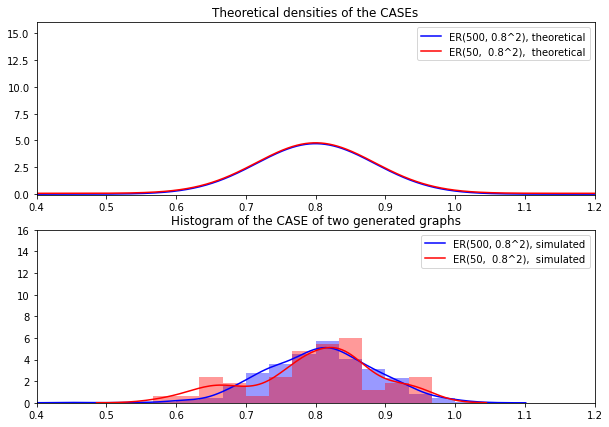

In [12]:
# fig02, (ax021, ax022, ax023) = plt.subplots(3, 1, figsize=(10, 10))#, sharex=True)
fig02, (ax021, ax022) = plt.subplots(2, 1, figsize=(10, 7))#, sharex=True)

# Theoretical distribution of the 
ax021.plot(np.linspace(bot, top, granular), 
           stats.norm.pdf(np.linspace(bot, top, granular), 
                          p, np.sqrt((1-p**2)/m)),
          color="b", label="ER({}, {}^2), theoretical".format(n,p))
ax021.plot(np.linspace(bot, top, granular), 
           stats.norm.pdf(np.linspace(bot, top, granular),
                          p, np.sqrt((1-p**2)/m)) + 0.08,
           color="red", label="ER({},  {}^2),  theoretical".format(m,p))
ax021.set_title("Theoretical densities of the CASEs")
ax021.set_xlim([bot, top])
ax021.legend()
ax021.set_ylim(-0.1, 16);
# Histogram/KDE generated from a graph
seaborn.distplot(X_hat_modified, bins=np.linspace(bot, top, nbins), ax=ax022,
                 hist_kws={"alpha": 0.4, "color": "b"},
                 kde_kws={"alpha": 1, "color":"b",
                          "label":"ER({}, {}^2), simulated".format(n,p)})
seaborn.distplot(Y_hat_modified, bins=np.linspace(bot, top, nbins), ax=ax022,
                 hist_kws={"alpha": 0.4, "color": "red"},
                kde_kws={"alpha": 1, "color":"red",
                         "label":"ER({},  {}^2),  simulated".format(m,p)})
ax022.set_title("Histogram of the CASE of two generated graphs")
ax022.set_xlim([bot, top])
ax022.set_ylim(0, 16);

In [13]:
fig02.savefig("../figures/visualization_validity.png", bbox_inches='tight')